<a href="https://colab.research.google.com/github/Dembelinho/LSTM_TimeSeries/blob/main/Electricity_Demand_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Block 1: Importing Necessary Libraries

In [ ]:
from datetime import datetime
from distutils.util import strtobool
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# Block 2: Function to Convert .tsf File to DataFrame

In [ ]:
# Converts the contents in a .tsf file into a dataframe and returns it along with other meta-data of the dataset: frequency, horizon, whether the dataset contains missing values and whether the series have equal lengths
# Parameters
# full_file_path_and_name - complete .tsf file path
# replace_missing_vals_with - a term to indicate the missing values in series in the returning dataframe
# value_column_name - Any name that is preferred to have as the name of the column containing series values in the returning dataframe
def convert_tsf_to_dataframe(
    full_file_path_and_name,
    replace_missing_vals_with="NaN",
    value_column_name="series_value",
):
    col_names = []
    col_types = []
    all_data = {}
    line_count = 0
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    found_data_tag = False
    found_data_section = False
    started_reading_data_section = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            # Strip white space from start/end of line
            line = line.strip()

            if line:
                if line.startswith("@"):  # Read meta-data
                    if not line.startswith("@data"):
                        line_content = line.split(" ")
                        if line.startswith("@attribute"):
                            if (
                                len(line_content) != 3
                            ):  # Attributes have both name and type
                                raise Exception("Invalid meta-data specification.")

                            col_names.append(line_content[1])
                            col_types.append(line_content[2])
                        else:
                            if (
                                len(line_content) != 2
                            ):  # Other meta-data have only values
                                raise Exception("Invalid meta-data specification.")

                            if line.startswith("@frequency"):
                                frequency = line_content[1]
                            elif line.startswith("@horizon"):
                                forecast_horizon = int(line_content[1])
                            elif line.startswith("@missing"):
                                contain_missing_values = bool(
                                    strtobool(line_content[1])
                                )
                            elif line.startswith("@equallength"):
                                contain_equal_length = bool(strtobool(line_content[1]))

                    else:
                        if len(col_names) == 0:
                            raise Exception(
                                "Missing attribute section. Attribute section must come before data."
                            )

                        found_data_tag = True
                elif not line.startswith("#"):
                    if len(col_names) == 0:
                        raise Exception(
                            "Missing attribute section. Attribute section must come before data."
                        )
                    elif not found_data_tag:
                        raise Exception("Missing @data tag.")
                    else:
                        if not started_reading_data_section:
                            started_reading_data_section = True
                            found_data_section = True
                            all_series = []

                            for col in col_names:
                                all_data[col] = []

                        full_info = line.split(":")

                        if len(full_info) != (len(col_names) + 1):
                            raise Exception("Missing attributes/values in series.")

                        series = full_info[len(full_info) - 1]
                        series = series.split(",")

                        if len(series) == 0:
                            raise Exception(
                                "A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series. Missing values should be indicated with ? symbol"
                            )

                        numeric_series = []

                        for val in series:
                            if val == "?":
                                numeric_series.append(replace_missing_vals_with)
                            else:
                                numeric_series.append(float(val))

                        if numeric_series.count(replace_missing_vals_with) == len(
                            numeric_series
                        ):
                            raise Exception(
                                "All series values are missing. A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series."
                            )

                        all_series.append(pd.Series(numeric_series).array)

                        for i in range(len(col_names)):
                            att_val = None
                            if col_types[i] == "numeric":
                                att_val = int(full_info[i])
                            elif col_types[i] == "string":
                                att_val = str(full_info[i])
                            elif col_types[i] == "date":
                                att_val = datetime.strptime(
                                    full_info[i], "%Y-%m-%d %H-%M-%S"
                                )
                            else:
                                raise Exception(
                                    "Invalid attribute type."
                                )  # Currently, the code supports only numeric, string and date types. Extend this as required.

                            if att_val is None:
                                raise Exception("Invalid attribute value.")
                            else:
                                all_data[col_names[i]].append(att_val)

                line_count = line_count + 1

        if line_count == 0:
            raise Exception("Empty file.")
        if len(col_names) == 0:
            raise Exception("Missing attribute section.")
        if not found_data_section:
            raise Exception("Missing series information under data section.")

        all_data[value_column_name] = all_series
        loaded_data = pd.DataFrame(all_data)

        return (
            loaded_data,
            frequency,
            forecast_horizon,
            contain_missing_values,
            contain_equal_length,
        )

---------------------------------------------

- This block provides an example of how to use the `convert_tsf_to_dataframe` function.
- It demonstrates how to call the function with the path to the .tsf file.
- The function returns loaded data as a DataFrame (`loaded_data`) and metadata such as frequency, forecast horizon, etc.
- After calling the function, it prints out the loaded data, frequency, forecast horizon, whether the dataset contains missing values, and whether the series have equal lengths.
- This example showcases the practical application of the `convert_tsf_to_dataframe` function for loading time series data from a .tsf file and inspecting its metadata.
- Users can replace `"/content/elecdemand_dataset.tsf"` with the actual path to their data file.

In [ ]:
# Example of usage
loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("/content/elecdemand_dataset.tsf") # Inser the path to your data
print("this is loadeed data -----------------------")
print(loaded_data)
print("this is frequency--- -----------------------")
print(frequency)
print("forecast horizon ??--- -----------------------")
print(forecast_horizon)
print("contain_missing_values ?? --- -----------------------")
print(contain_missing_values)
print("contain_equal_length ?? --- -----------------------")
print(contain_equal_length)


this is loadeed data -----------------------
  series_name     start_timestamp  \
0          T1 2014-01-01 00:00:01   

                                        series_value  
0  [3.91464713, 3.672549608, 3.49753903, 3.339144...  
this is frequency--- -----------------------
half_hourly
forecast horizon ??--- -----------------------
None
contain_missing_values ?? --- -----------------------
False
contain_equal_length ?? --- -----------------------
True


---------------------------------

- This block extracts the "series_value" column from the loaded data DataFrame.
- It converts the extracted series values into a numpy array of float values.
- First, it converts the series values to a DataFrame using `pd.DataFrame.from_records(data)`.
- Then, it converts the DataFrame to a numpy array using `.to_numpy()`.
- Finally, it reshapes the array to have the shape `(number_of_series, length_of_series)`.
- The resulting `data` array is ready for further processing or model training, such as LSTM modeling for time series data.

In [ ]:
# Extract only the "Series_value" to an Array of float
data = loaded_data["series_value"]

data = pd.DataFrame.from_records(data).to_numpy()

data = np.reshape(data, (data.shape[1], data.shape[0]))

In [ ]:
loaded_data["start_timestamp"]

0   2014-01-01 00:00:01
Name: start_timestamp, dtype: datetime64[ns]

In [ ]:
data

array([[3.91464713],
       [3.67254961],
       [3.49753903],
       ...,
       [3.80941459],
       [4.13594558],
       [4.21704656]])

In [ ]:
data.shape

(17520, 1)

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
#Check for stationarity of time series
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(data)

if(pvalue > 0.05):
    print("Our data is not stationary ; pvalue = ",pvalue)
else :
    print("Our data is stationary ; pvalue = ",pvalue)

Our data is stationary ; pvalue =  0.0005510194996223703


# Block 3: Creating Sequences for LSTM Model

This code creates sequences of length seq_length from this half-hourly data. It also generates corresponding timestamps for each sequence.

In [ ]:
# Timestamps
start_timestamp = pd.Timestamp("2014-01-01 00:00:01")
freq = "30T"  # Half-hourly frequency

# Create timestamps for each data point
timestamps = pd.date_range(start=start_timestamp, periods=len(data), freq=freq)

# Function to create sequences
def create_sequences(data, timestamps, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y), timestamps[seq_length:]

# Define sequence length (number of time steps to look back)
seq_length = 3

# Create sequences
X, y, timestamps = create_sequences(data, timestamps, seq_length)

# Split data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
timestamps_train, timestamps_test = timestamps[:split], timestamps[split:]

# Print shapes of the resulting arrays
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (14013, 3, 1)
y_train shape: (14013, 1)
X_test shape: (3504, 3, 1)
y_test shape: (3504, 1)


**data is stationary bcz pvalue < 5%**

# Block 4: Defining and Training LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

To use an LSTM model for time series data, you can follow these general steps:

1. Prepare your data: Ensure that your time series data is properly formatted and split into input sequences and corresponding output values.
2. Define your LSTM model: Create an LSTM model using a deep learning framework such as TensorFlow or PyTorch.
3. Train your model: Fit the LSTM model to your training data.
4. Evaluate your model: Assess the performance of your trained model on a separate validation or test dataset.
5. Make predictions: Use your trained LSTM model to make predictions on new or unseen data.

In [ ]:
# Define LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

print(model.summary())

# Train model
hr= model.fit(X_train, y_train, epochs=100, batch_size=32)

# Evaluate model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 50)             10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100
438/438 [==============================] - 8s 8ms/step - loss: 0.9527
Epoch 2/100
438/438 [==============================] - 3s 6ms/step - loss: 0.0966
Epoch 3/100
438/438 [==============================] - 3s 6ms/step - loss: 0.0349
Epoch 4/100
438/438 [==========

-----------------------------------------

## Block 5: Plotting Real vs Predicted Values

In [ ]:
import matplotlib.pyplot as plt

This code will create a scatter plot where each point represents a pair of real and predicted values.

110/110 [==============================] - 3s 6ms/step


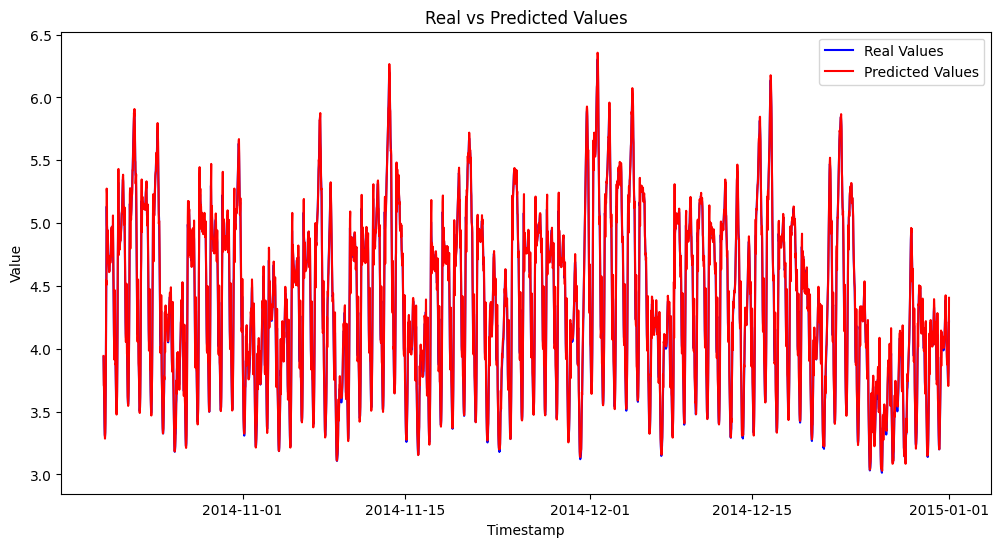

In [ ]:
# Make predictions
predictions = model.predict(X_test)

# Plot real vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(timestamps_test, y_test, label='Real Values', color='blue')
plt.plot(timestamps_test, predictions, label='Predicted Values', color='red')
plt.title('Real vs Predicted Values')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()


<ipython-input-26-adca871ef5e2>:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(y_test[:100], 'r', label="Real Values" , color='blue')
<ipython-input-26-adca871ef5e2>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(predictions[:100], 'r', label='Predicted Values' , color='red')


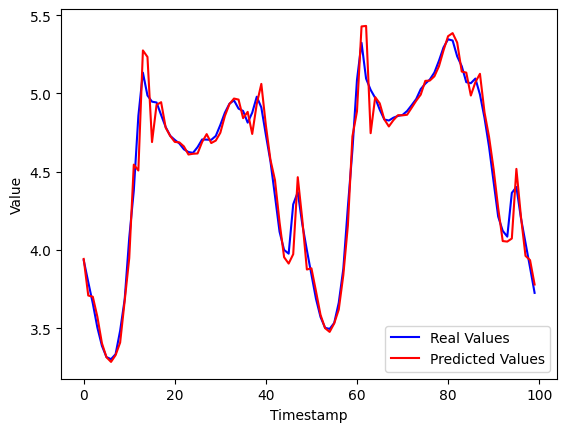

In [ ]:
plt.plot(y_test[:100], 'r', label="Real Values" , color='blue')
plt.plot(predictions[:100], 'r', label='Predicted Values' , color='red')
plt.ylabel('Value')
plt.xlabel('Timestamp')
plt.legend()
plt.show();

## Block 6: Scatter Plot of Real vs Predicted Values

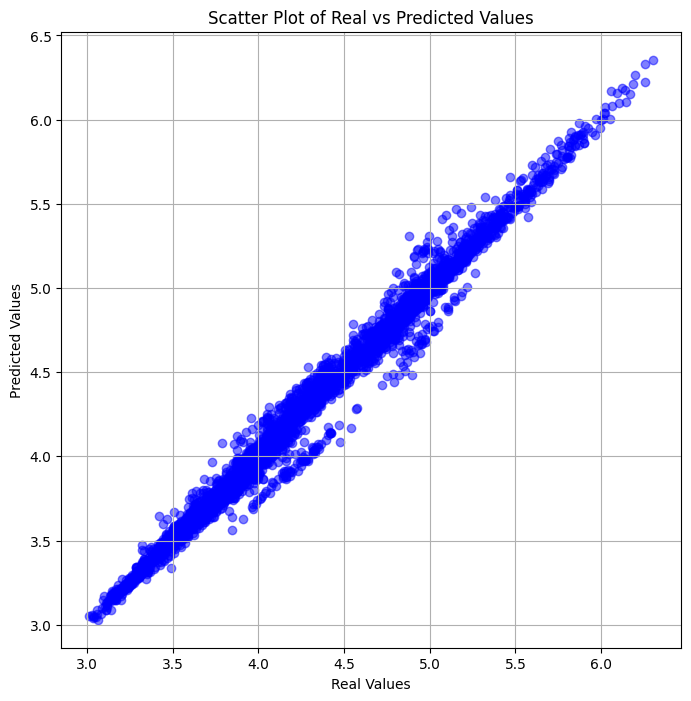

In [ ]:
# Scatter plot of real vs predicted values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, predictions, color='blue', alpha=0.5)
plt.title('Scatter Plot of Real vs Predicted Values')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()


A perfect prediction would result in all points lying on a diagonal line. Deviations from this line indicate the model's performance.

# Block 7: SARIMA Model Fitting, Prediction, and Evaluation

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# Define SARIMA or ARIMA model
sarima_model = SARIMAX(y_train, order=(1, 0, 1), seasonal_order=(0, 1, 1, 24))
sarima_fit = sarima_model.fit()

In [ ]:
print(sarima_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                14013
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 24)   Log Likelihood               14758.978
Date:                            Wed, 14 Feb 2024   AIC                         -29509.956
Time:                                    11:42:32   BIC                         -29479.772
Sample:                                         0   HQIC                        -29499.907
                                          - 14013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9844      0.001    737.351      0.000       0.982       0.987
ma.L1          0.7840      0.005   

In [ ]:
# Make predictions
sarima_predictions = sarima_fit.forecast(steps=len(y_test))

In [ ]:
# Evaluate SARIMA model
sarima_mse = mean_squared_error(y_test, sarima_predictions)
print("SARIMA Mean Squared Error:", sarima_mse)

SARIMA Mean Squared Error: 0.431884347473692


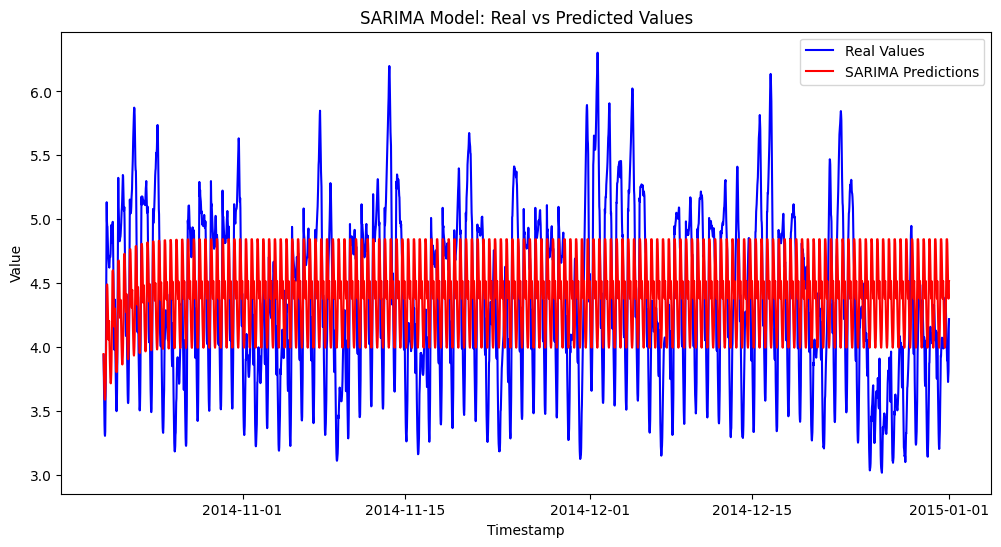

In [ ]:
# Plot real vs predicted values for SARIMA model
plt.figure(figsize=(12, 6))
plt.plot(timestamps_test, y_test, label='Real Values', color='blue')
plt.plot(timestamps_test, sarima_predictions, label='SARIMA Predictions', color='red')
plt.title('SARIMA Model: Real vs Predicted Values')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

# Block 8: ARIMA Model Fitting, Prediction, and Evaluation

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# Example of ARIMA model
arima_model = ARIMA(y_train, order=(5,1,0))
arima_fit = arima_model.fit()

In [ ]:
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                14013
Model:                 ARIMA(5, 1, 0)   Log Likelihood               13168.694
Date:                Wed, 14 Feb 2024   AIC                         -26325.388
Time:                        11:45:58   BIC                         -26280.102
Sample:                             0   HQIC                        -26310.313
                              - 14013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9959      0.006    171.087      0.000       0.984       1.007
ar.L2         -0.3518      0.008    -42.466      0.000      -0.368      -0.336
ar.L3          0.2040      0.016     13.059      0.0

In [ ]:
arima_predictions = arima_fit.forecast(steps=len(y_test))

In [ ]:
# Evaluate ARIMA model
arima_mse = mean_squared_error(y_test, arima_predictions)
print("ARIMA Mean Squared Error:", arima_mse)

ARIMA Mean Squared Error: 0.5293410988644737


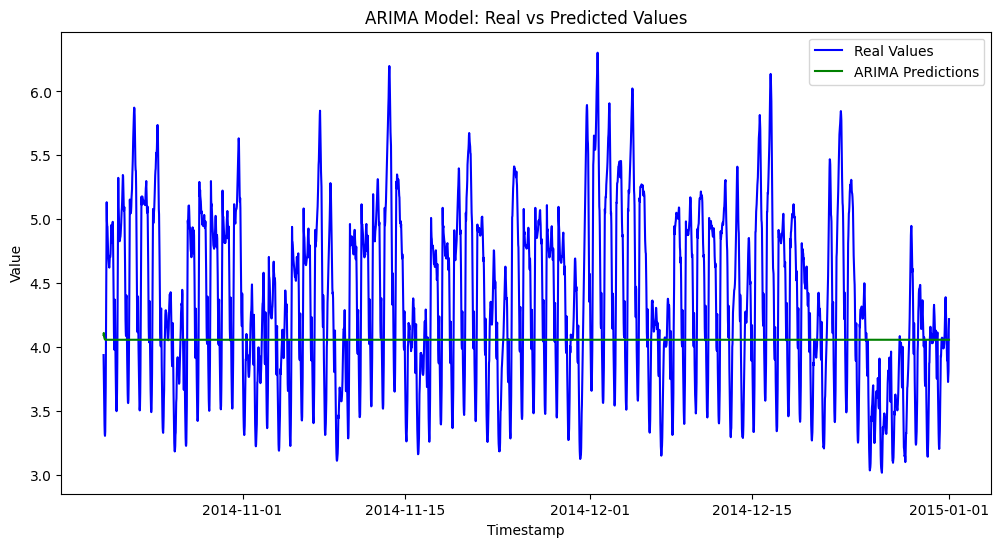

In [ ]:
# Plot real vs predicted values for ARIMA model
plt.figure(figsize=(12, 6))
plt.plot(timestamps_test, y_test, label='Real Values', color='blue')
plt.plot(timestamps_test, arima_predictions, label='ARIMA Predictions', color='green')
plt.title('ARIMA Model: Real vs Predicted Values')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()